In [3]:
import numpy as np
import pandas as pd 



In [22]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')#I USE THIS LIBRary to ignore the warning 
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import datetime
from pandas import read_csv

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf


from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_csv('bitcoin_price.csv', parse_dates=['Date'])
df.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-02-20,11231.8,11958.5,11231.80,11403.7,"9,926,540,000","189,536,000,000"
1,2018-02-19,10552.6,11273.8,10513.20,11225.3,"7,652,090,000","178,055,000,000"
2,2018-02-18,11123.4,11349.8,10326.00,10551.8,"8,744,010,000","187,663,000,000"
3,2018-02-17,10207.5,11139.5,10149.40,11112.7,"8,660,880,000","172,191,000,000"
4,2018-02-16,10135.7,10324.1,9824.82,10233.9,"7,296,160,000","170,960,000,000"


In [7]:
print (df.describe())
print ("=============================================================")
print (df.dtypes)

               Open          High           Low         Close
count   1760.000000   1760.000000   1760.000000   1760.000000
mean    1479.574239   1536.991108   1418.251273   1485.747000
std     2950.457188   3092.950362   2780.859459   2959.265478
min       68.500000     74.560000     65.530000     68.430000
25%      274.730000    279.857500    268.640000    274.875000
50%      480.715000    495.195000    472.510000    482.810000
75%      870.085000    900.222500    831.682500    871.370000
max    19475.800000  20089.000000  18974.100000  19497.400000
Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                object
Market Cap            object
dtype: object


In [9]:
df1 = df[['Date','Close']]
df1.head(10)

,Date,Close
0,2018-02-20,11403.70
1,2018-02-19,11225.30
2,2018-02-18,10551.80
3,2018-02-17,11112.70
4,2018-02-16,10233.90
5,2018-02-15,10166.40
6,2018-02-14,9494.63
7,2018-02-13,8598.31
8,2018-02-12,8926.57
9,2018-02-11,8129.97


In [10]:
# Setting the Date as Index
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print ("========================")
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
             Close
Date              
2013-04-28  134.21
2013-04-29  144.54
2013-04-30  139.00
              Close
Date               
2018-02-18  10551.8
2018-02-19  11225.3
2018-02-20  11403.7


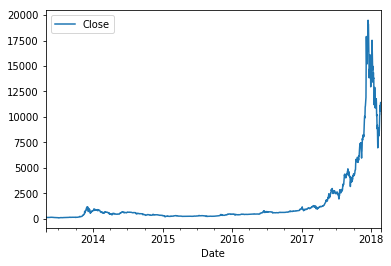

In [11]:
df_ts.plot()

In [12]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

In [13]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df_ts['Close']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -1.360453
p-value                           0.601082
#lags Used                       25.000000
Number of Observations Used    1734.000000
Critical Value (1%)              -3.434127
Critical Value (5%)              -2.863208
Critical Value (10%)             -2.567658
dtype: float64


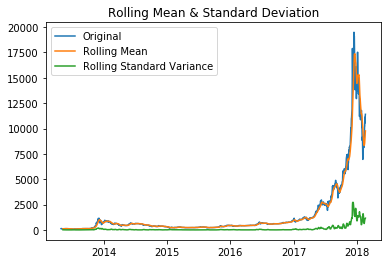

In [14]:
# Let's plot the 12-Month Moving Rolling Mean & Variance and find Insights
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()

plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

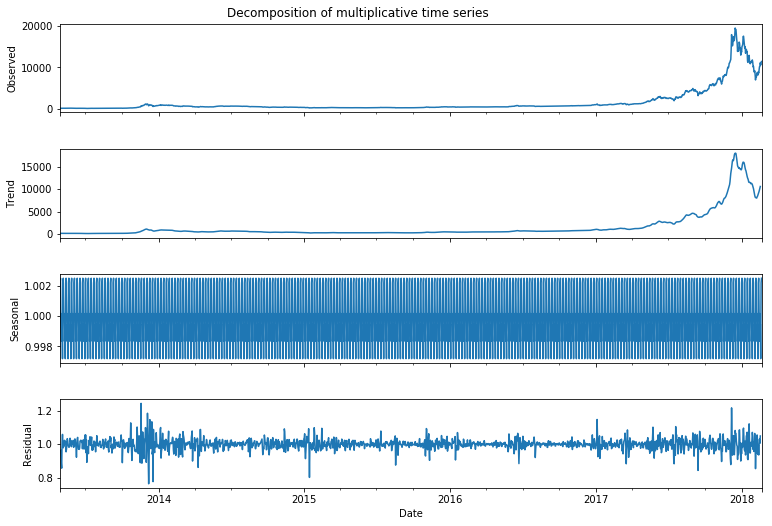

In [15]:
#vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()


In [16]:
# Lets Resample the data by Month and analyze again
df_ts_m = df_ts.resample('M').mean()
print (type(df_ts_m))
print (df_ts_m.head(3))

<class 'pandas.core.frame.DataFrame'>
                 Close
Date                  
2013-04-30  139.250000
2013-05-31  119.993226
2013-06-30  107.761333


In [17]:
tsm = df_ts_m['Close']
print (type(tsm))

<class 'pandas.core.series.Series'>


In [18]:
# Stationarity Check
test_stationarity(tsm)

Results of Dickey-Fuller Test:
Test Statistic                  2.126442
p-value                         0.998816
#lags Used                      6.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


trying monthly approach 

In [20]:
# lets try to make the "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
# Stationarity Check
test_stationarity(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                 -5.098131
p-value                         0.000014
#lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


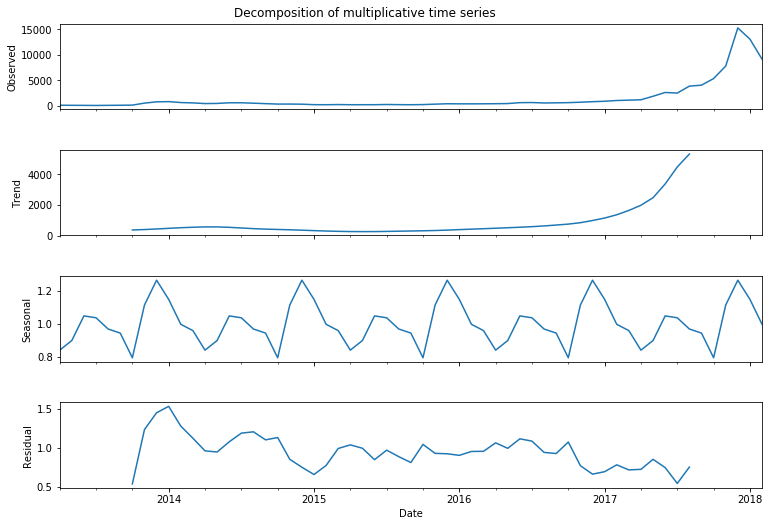

In [19]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

Conclusion

This we see a somewhat clarity on the Seasonality graph

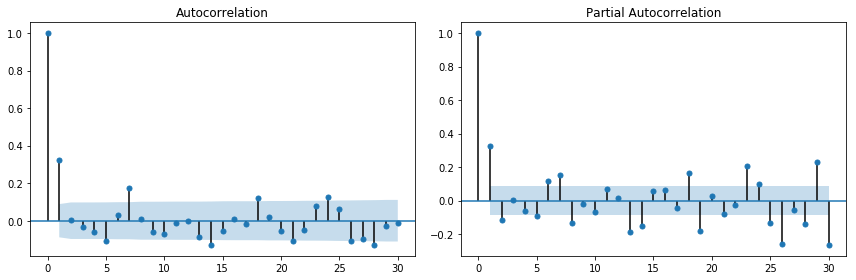

In [21]:
# Let's plot ACF & PACF graphs to visualize AR & MA components

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [25]:
crypto_data = {}

crypto_data['bitcoin'] = pd.read_csv('bitcoin_price.csv', parse_dates=['Date'])

In [26]:
df_bitcoin = pd.DataFrame(crypto_data['bitcoin'])

df_bitcoin = df_bitcoin[['Date','Close']]
df_bitcoin.set_index('Date', inplace = True)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1759
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12013.312
Method:                       css-mle   S.D. of innovations            223.772
Date:                Wed, 12 Jun 2019   AIC                          24040.624
Time:                        01:07:39   BIC                          24078.932
Sample:                    02-19-2018   HQIC                         24054.781
                         - 04-28-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.4478      6.170     -1.045      0.296     -18.542       5.646
ar.L1.D.Close     0.1094      0.023      4.663      0.000       0.063       0.155
ar.L2.D.Close    -0.0664      0.024     

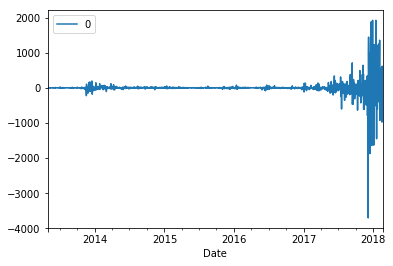

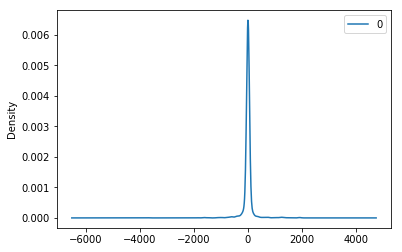

                 0
count  1759.000000
mean      0.027541
std     223.924705
min   -3704.719115
25%      -3.519705
50%       4.778104
75%      11.515099
max    1931.990577


In [27]:
# fit model
model = ARIMA(df_bitcoin, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 1518.182


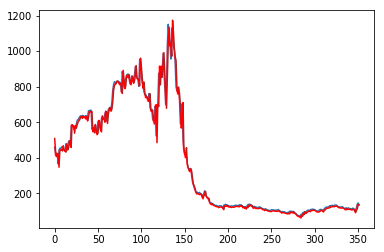

In [28]:
#predicting future values

X = df_bitcoin.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()